In [16]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.optimizers import Adam
import os
from glob import glob
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
from PIL import Image

In [2]:
IMGWIDTH = 256

In [3]:
class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [4]:
class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)

In [5]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


In [6]:
class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [7]:
# 1 - Load the model and its pretrained weights
classifier = Meso4()
# classifier.load('dataset/Meso4_DF.h5')

In [8]:
# 2 - Minimial image generator
dataGenerator = ImageDataGenerator(rescale=1./255)
generator = dataGenerator.flow_from_directory(
        'dataset/train_images',
        target_size=(256, 256),
        batch_size=1,
        class_mode='binary',
        subset='training')
generator.class_indices

# there should only be 2 classes, if not run the below to get rid or find the weird file:
# import os
# dir = os.listdir('dataset/test_images')
# print(dir)
# file_path = ('dataset/test_images/.ipynb_checkpoints')
# os.rmdir(file_path)

Found 18 images belonging to 2 classes.


{'fake': 0, 'real': 1}

In [9]:
# change directory accordingly
CURR_DIR = os.getcwd()
print(CURR_DIR)
INPUT_DIR = CURR_DIR + "/deepfake-detection-challenge/train_sample_videos"

videopaths = sorted(glob(os.path.join(INPUT_DIR, "*.mp4")))
print("Number of videos:", len(videopaths))

/Users/dugongzzz/Documents/GitHub/cmpt733-deepfake-detection
Number of videos: 18


In [10]:
X, y = generator.next()
for i in range(len(videopaths)):
    classifier.fit(X, y)

In [11]:
dataGenerator_test = ImageDataGenerator(rescale=1./255)
generator_test = dataGenerator_test.flow_from_directory(
        'dataset/test_images',
        target_size=(256, 256),
        batch_size=1,
        class_mode='binary',
        subset='training')
generator_test.class_indices

Found 4 images belonging to 2 classes.


{'fake': 0, 'real': 1}


Correct prediction: True
Predicted : [[0.55778277]] 
Real class : [1.]


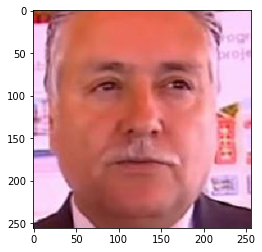

In [40]:
# 3 - Predict
X1, y1 = generator_test.next()
print(f"\nCorrect prediction: {round(classifier.predict(X1)[0][0]) == y1[0]}")
print('Predicted :', classifier.predict(X1), '\nReal class :', y1)
plt.imshow(X1[0])